# Pneumonia Classifier

**Name:** Pneumonia Classifier

**Author:** Sharome Burton

**Date:** 07/25/2021

**Description:** Machine learning model used to determine the presence of pneumonia in a patient given an image of a chest X-ray.

**Kaggle:** https://www.kaggle.com/sharomeethan/pneumonia-classifier-cnn-acc-91

**GitHub:** 

<img src="https://i.imgur.com/jZqpV51.png"
     alt="pneumonia-examples"
     style="left; margin-right: 10px;" />


## 1. Problem definition
> How accurately can we identify pneumonia in the lungs of a patient given their chest X-ray?

## 2. Data
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.
   
* `/test` - the test set
* `/train` - the training set
* `/val` - the validation set


Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

## 3. Evaluation 

> **Goal:** Detect pneumonia in a patient from their medical imagery at >90% accuracy

Guide: https://www.kaggle.com/kashyapgohil/pneumonia-detection-using-cnn



In [142]:
# Kaggle input
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Importing tools

In [143]:
# Import Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import cv2 # OpenCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# Loading Dataset

In [144]:
# Get data

LABELS = ('PNEUMONIA','NORMAL')
IMG_SIZE=150
def get_data(data_dir):
    data = []
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping Images
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [145]:
train_raw = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test_raw = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val_raw = get_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.5.2) /tmp/pip-req-build-gvmai4nm/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /tmp/pip-req-build-gvmai4nm/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


OpenCV(4.5.2) /tmp/pip-req-build-gvmai4nm/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) /tmp/pip-req-build-gvmai4nm/opencv/modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Exploratory Data Analysis (EDA)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

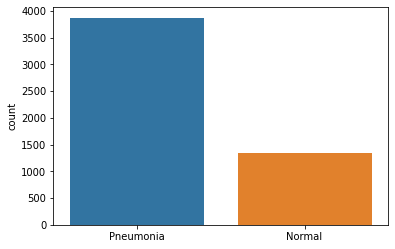

In [146]:
# Training Data
count = []
for i in train_raw:
    if(i[1] == 1):
        count.append("Normal")
    else:
        count.append('Pneumonia')

sns.countplot(count)

Data appears imbalanced, with Pneumonia cases outnumbering number cases 3:1.

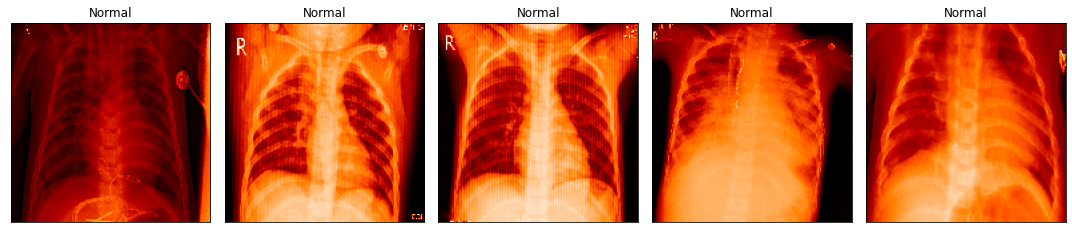

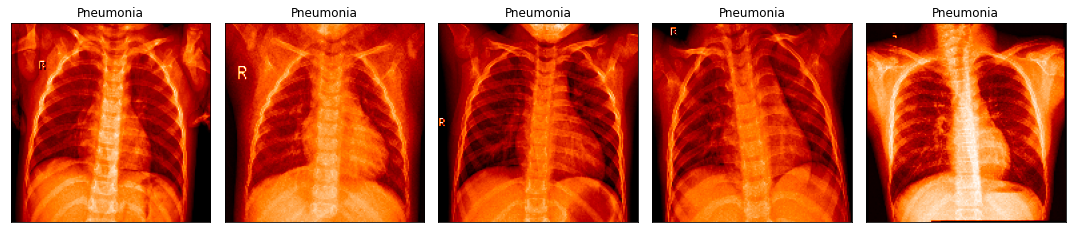

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
#     if (train_raw[i][1] == 1):
        img = train_raw[i][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Normal")
fig.tight_layout()    
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
#     if (train_raw[i][1] == 0):
        img = train_raw[-(i+1)][0]
        ax.imshow(img, cmap='gist_heat')
        ax.set_title("Pneumonia")
fig.tight_layout()
plt.show()



# Splitting, and normalizing data

We will:
* Split the data into X (features) and y (labels)
* Normalize the data from 0-255 to 0-1 for quicker conversion by Convolutional Neural Network
* Resize data to shape for deep learning

In [148]:
#Splitting data

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for image, label in train_raw:
    X_train.append(image)
    y_train.append(label)
    
for image, label in val_raw:
    X_val.append(image)
    y_val.append(label)
    
for image, label in test_raw:
    X_test.append(image)
    y_test.append(label)

In [149]:
# Normalize the data
X_train = np.array(X_train) / 255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [150]:
# Resize data for deep learning 
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)


# Data augmentation
 In order to avoid overfitting, we must artificially expand our training dataset with small transformations (without changing the label) called augmentation techniques. Some popular augmentation techniques are grayscales, flips, random crops, translations, and rotations.
 
By applying some of these augmentations, we are able to eventually produce a more robust model.

In [151]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)


# Training model

We will use a convolutional neural network to solve this problem.

<img src="https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg"
     alt="cnn-explained"
     style="float: left; margin-right: 10px;" />

Source: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [159]:
np.random.seed = 18
NUM_EPOCHS = 18

model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (160,160,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 160, 160, 32)      320       
_________________________________________________________________
batch_normalization_25 (Batc (None, 160, 160, 32)      128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 80, 80, 64)        18496     
_________________________________________________________________
dropout_20 (Dropout)         (None, 80, 80, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 80, 80, 64)        256       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 40, 40, 64)       

In [160]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

history = model.fit(datagen.flow(X_train, y_train, batch_size = 32),
                    epochs = NUM_EPOCHS,
                    validation_data = datagen.flow(X_val, y_val),
                    callbacks = [learning_rate_reduction]
                   )

Epoch 1/18
163/163 [==============================] - 13s 70ms/step - loss: 1.4608 - accuracy: 0.8056 - val_loss: 25.2453 - val_accuracy: 0.5000
Epoch 2/18
163/163 [==============================] - 11s 69ms/step - loss: 0.2862 - accuracy: 0.8877 - val_loss: 35.4459 - val_accuracy: 0.5000
Epoch 3/18
163/163 [==============================] - 10s 62ms/step - loss: 0.2561 - accuracy: 0.9047 - val_loss: 34.1744 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/18
163/163 [==============================] - 10s 61ms/step - loss: 0.1634 - accuracy: 0.9448 - val_loss: 4.7306 - val_accuracy: 0.5625
Epoch 5/18
163/163 [==============================] - 11s 64ms/step - loss: 0.1360 - accuracy: 0.9538 - val_loss: 1.2647 - val_accuracy: 0.6875
Epoch 6/18
163/163 [==============================] - 10s 61ms/step - loss: 0.1268 - accuracy: 0.9559 - val_loss: 7.6904 - val_accuracy: 0.5000
Epoch 7/18
163/163 [==============================] 

In [161]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 7ms/step - loss: 0.2715 - accuracy: 0.9215
Loss of the model is -  0.2715132534503937
20/20 [==============================] - 0s 7ms/step - loss: 0.2715 - accuracy: 0.9215
Accuracy of the model is -  92.14743375778198 %


# Training analysis

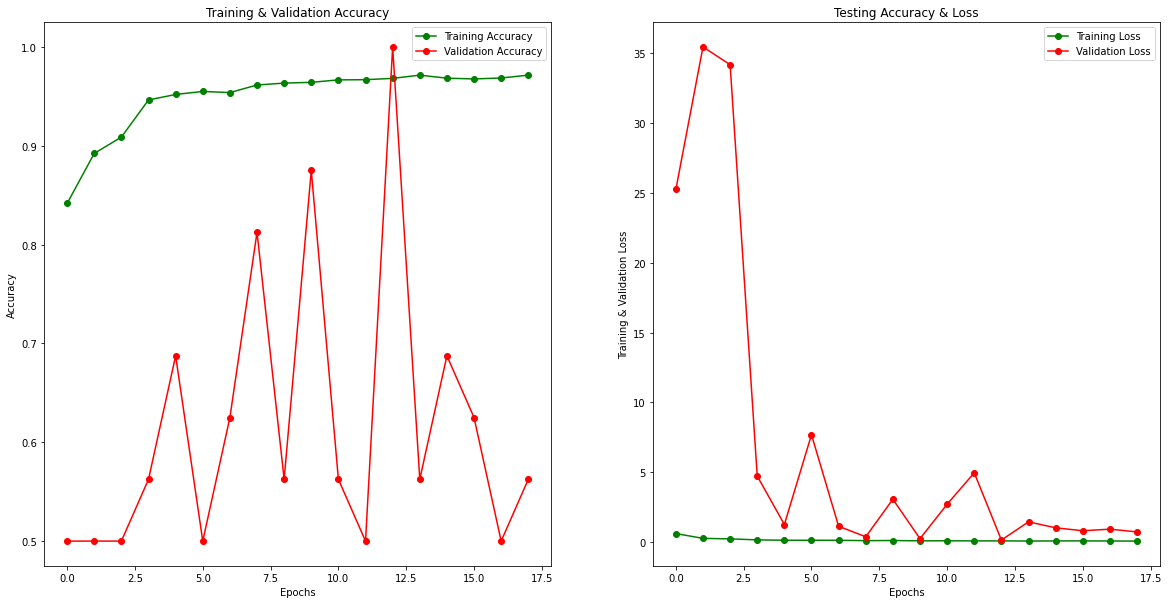

In [162]:
epochs = [i for i in range(NUM_EPOCHS)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

# Model analysis

In [163]:
y_preds = model.predict_classes(X_test)
y_preds = y_preds.reshape(1,-1)[0]
y_preds

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [164]:
# Classification report
print(classification_report(y_test, y_preds, target_names= ['Pneumonia (0)', 'Normal (1)']))

               precision    recall  f1-score   support

Pneumonia (0)       0.94      0.93      0.94       390
   Normal (1)       0.89      0.91      0.90       234

     accuracy                           0.92       624
    macro avg       0.91      0.92      0.92       624
 weighted avg       0.92      0.92      0.92       624



<AxesSubplot:>

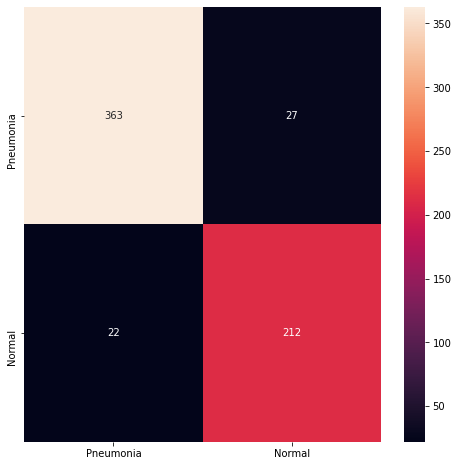

In [165]:
# Confusion matrix
plt.figure(figsize = (8,8))
sns.heatmap(confusion_matrix(y_test, y_preds), annot=True, fmt='', xticklabels=['Pneumonia','Normal'], yticklabels=['Pneumonia','Normal'])

# Predictions

In [166]:
correct = np.nonzero(y_preds == y_test)[0]
incorrect = np.nonzero(y_preds != y_test)[0]
correct[:10], incorrect[:10]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 10,  11,  17,  22,  32,  33,  64,  67,  87, 112]))

In [174]:
def plot_preds(correct, incorrect, X_test, y_test, n=4, corr=True):
    """
    Prints correct or incorrect predictions.
    """
    labels=['pneumonia', 'normal']
    
    plt.figure(figsize=(10,15))
    
    # Correct
    if corr:
        print("Correct predictions:\n")
        i=0
        for c in correct[:n]:
            plt.subplot(((n+1)//2)+1, 2, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(X_test[c])
            plt.title(f'Predicted: {labels[y_preds[c]]}, Actual: {labels[y_test[c]]}')
            plt.tight_layout()
            i+=1

    # Incorrect
    else:
        print("Incorrect predictions:\n")
        i=0
        for inc in incorrect[:n]:
            plt.subplot(((n+1)//2)+1, 2, i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(X_test[inc])
            plt.title(f'Predicted: {labels[y_preds[inc]]}, Actual: {labels[y_test[inc]]}')
            plt.tight_layout()
            i+=1

## Correct Predictions

Correct predictions:



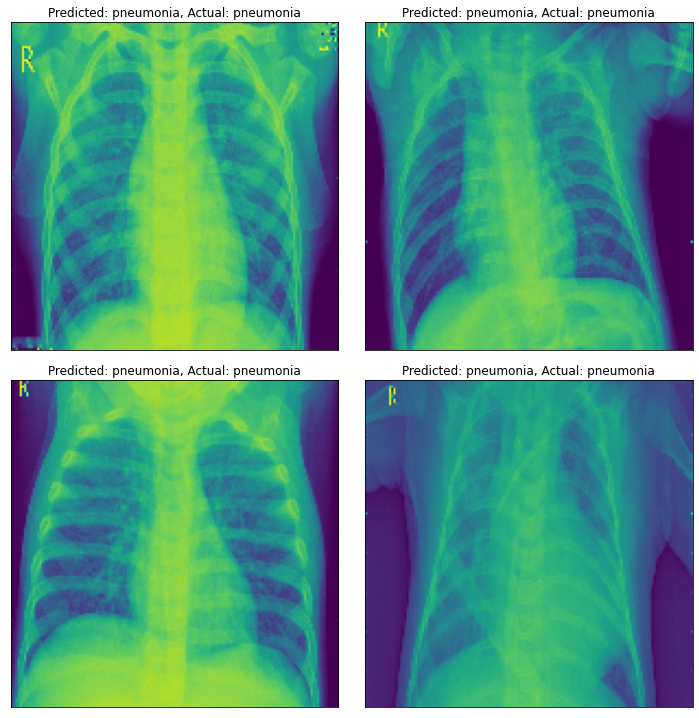

In [175]:
plot_preds(correct, incorrect, X_test, y_test)

## Incorrect Predicitons

Incorrect predictions:



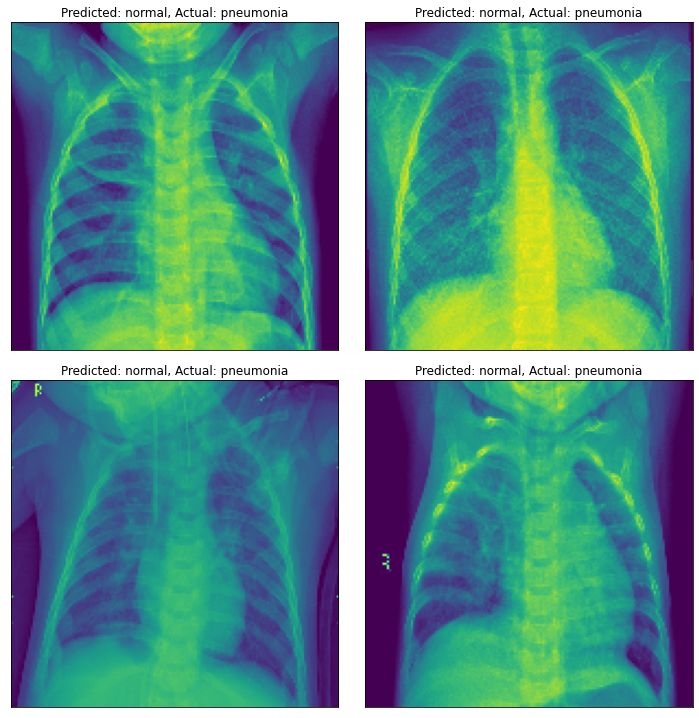

In [176]:
plot_preds(correct, incorrect, X_test, y_test, corr=False)

# Conclusion

Model shows a reasonable precision of **92%** and f-1 score of **0.92**. Additional preprocessing of the images and tuning of the model could be performed to improve this score, but it has passed the evaluation metric for this version.